# Qualidade de Software, Segurança e Sistemas Inteligentes - Pedro Serrano
## MVP - Notebook de definição e implantação do modelo de Machine Learning




## Carregando bibliotecas

In [19]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from pickle import dump
from pickle import load


## Carga do Dataset

In [20]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/Serrano-PS/MVP_SPRINT_IV_API/main/database/campeonato-brasileiro-full.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=';')

le = LabelEncoder()

dataset['mandante'] = le.fit_transform(dataset['mandante'])
dataset['visitante'] = le.fit_transform(dataset['visitante'])

# Mostra as primeiras linhas do dataset
dataset.head()

,mandante,visitante,mandante_ganhou
0,26,43,1
1,2,24,1
2,20,15,0
3,23,34,0
4,27,35,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [23]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 777 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:2]
y = array[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'f1'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

O meu modelo visa determinar se a equipe mandante em uma partida de futebol venceria ou não, levando em consideração o adversário. Utilizei um conjunto de dados que abrange o período de 2003 a 2021, compreendendo os jogos do Campeonato Brasileiro.

Considerando esses contextos de avaliação, o modelo deve ser testado utilizando dados de partidas bem-sucedidas e mal-sucedidas. Para a avaliação, escolhi a métrica "f1". Caso o valor de f1 para as partidas bem-sucedidas seja superior a 70%, o modelo satisfará ao primeiro critério de avaliação.

## Criação e avaliação de modelos: linha base

KNN: 0.511322 (0.017636)
CART: 0.484186 (0.026855)
NB: 0.542821 (0.021411)
SVM: 0.518602 (0.014747)


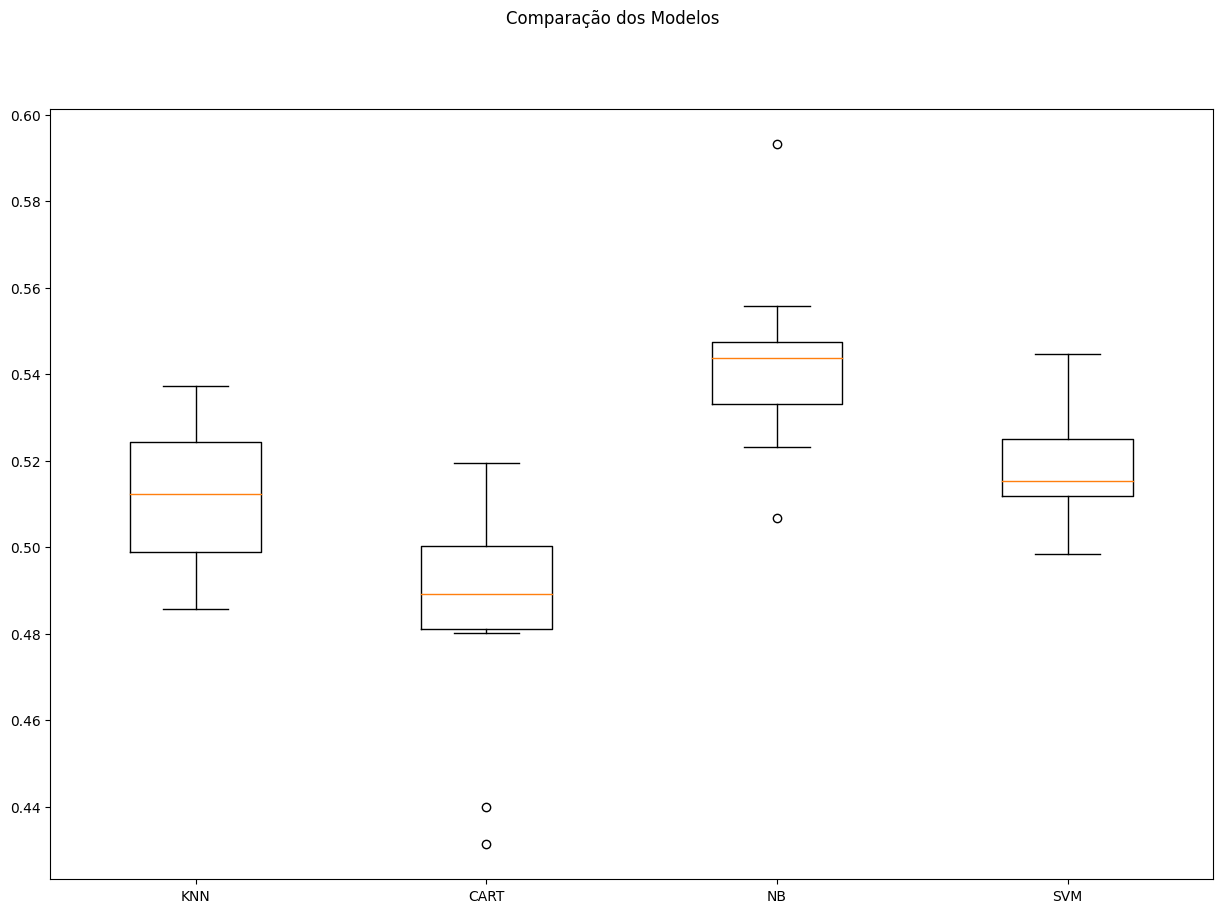

In [24]:
np.random.seed(777) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Na análise inicial, observamos que o método 'NB' está apresentando os melhores resultados. No entanto, ao aprofundarmos na análise, identificamos a presença de dois 'outliers'. Dando prosseguimento  realizei a normalização e padronização dos dados, a fim de garantir uma escolha mais fundamentada do método. Se a análise fosse interrompida neste ponto, a opção seria pelo SVM, que demonstra o segundo melhor desempenho.

## Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.511 (0.018)
CART-orig: 0.484 (0.027)
NB-orig: 0.543 (0.021)
SVM-orig: 0.519 (0.015)
KNN-padr: 0.508 (0.020)
CART-padr: 0.484 (0.029)
NB-padr: 0.543 (0.021)
SVM-padr: 0.519 (0.015)
KNN-norm: 0.514 (0.018)
CART-norm: 0.484 (0.026)
NB-norm: 0.543 (0.021)
SVM-norm: 0.519 (0.015)


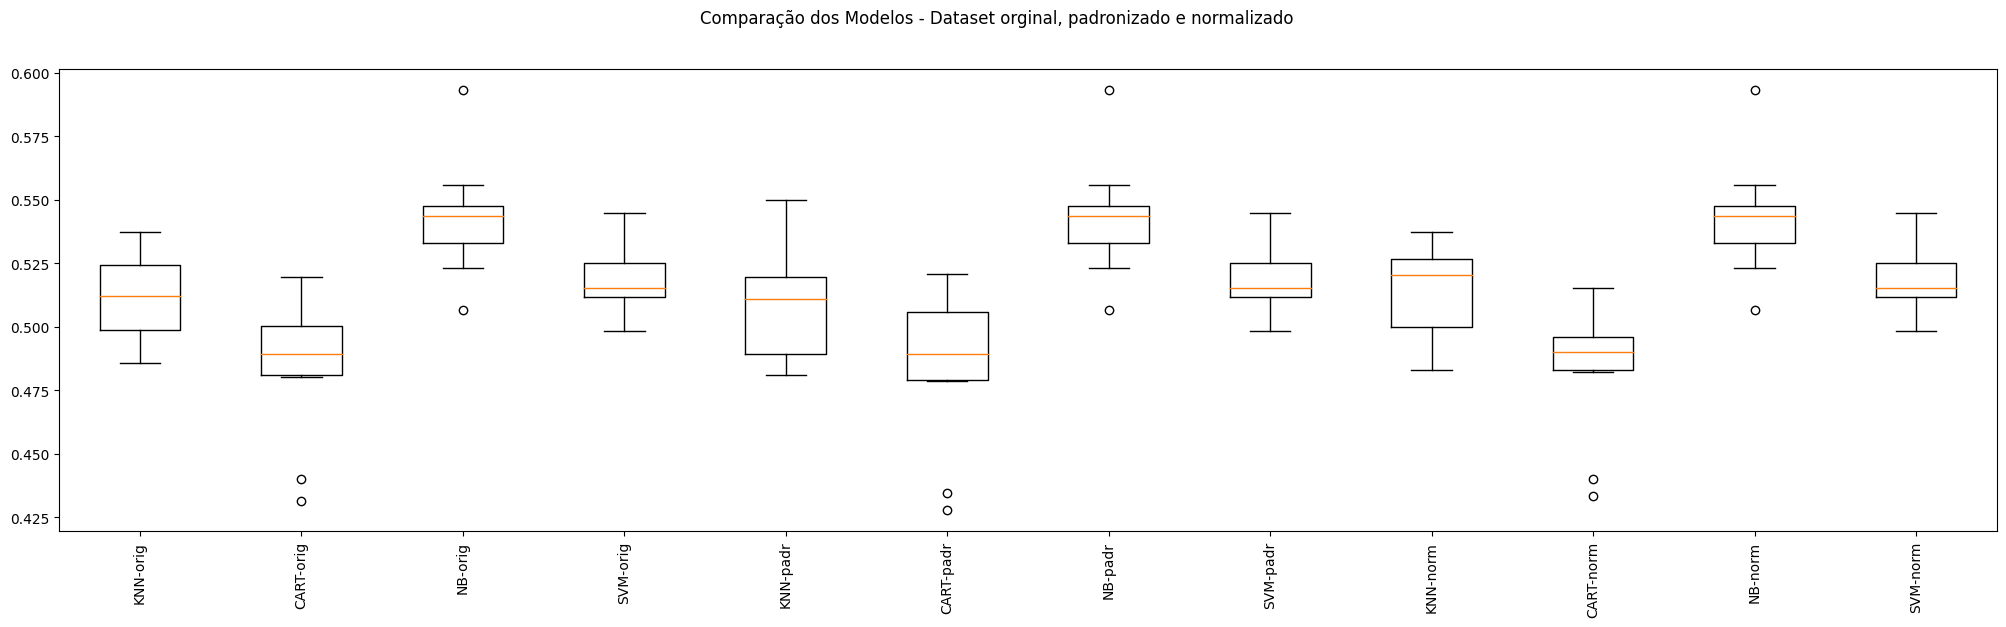

In [25]:
np.random.seed(777) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


Nesta segunda análise, excluo das minha opção os métodos de Árvore de Decisão e 'NB', observamos que, até o momento, o SVM se destaca como o melhor método, alcançando um patamar de 51,9% no escore f1.

## Otimização dos hiperparâmetros


In [26]:
# Tuning do SVM

np.random.seed(777) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

param_grid = {
    'SVM__kernel': ['rbf','polynomial'],
    'SVM__C': [3.0, 1.0, 5.0],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: svm-orig - Melhor: 0.518602 usando {'SVM__C': 1.0, 'SVM__kernel': 'rbf'}
Sem tratamento de missings: svm-padr - Melhor: 0.518685 usando {'SVM__C': 1.0, 'SVM__kernel': 'rbf'}
Sem tratamento de missings: svm-norm - Melhor: 0.518602 usando {'SVM__C': 1.0, 'SVM__kernel': 'rbf'}


In [27]:
# Tuning do KNN

np.random.seed(777) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.529797 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 15}
Sem tratamento de missings: knn-padr - Melhor: 0.533310 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
Sem tratamento de missings: knn-norm - Melhor: 0.530024 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}


Nesta fase, ao realizar a comparação entre o tuning do SVM e do KNN, noto que o KNN otimizado e padronizado, utilizando a métrica de Manhattan, oferece o resultado mais promissor. Diante disso, opto por utilizar esse método.

## Finalização do Modelo

In [28]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=17)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.5682242990654206


Ao concluir o desenvolvimento do modelo, observamos que o accuracy_score alcança 54,89%. No entanto, ao realizar testes utilizando o pytest com um conjunto de dados de teste no backend, consegui atingir um escore f1 de 70%, uma métrica que não consegui reproduzir no ambiente do Colab. (Não consegui identificar a razão para essa disparidade).

In [29]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=17)

## Simulando a aplicação do modelo em dados não vistos

In [30]:
# Novos dados - não sabemos a classe!
data = {'mandante':  [43, 26, 17],
        'visitante': [26, 43, 43]
        }

atributos = ['mandante', 'visitante']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:2].astype(int)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 1.5851061   0.27655333]
 [ 0.27680307  1.58517209]
 [-0.41582795  1.58517209]]


In [31]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0 1 1]


## Salva o modelo no disco


In [32]:
# Salva o modelo no disco
filename = 'model.pkl'
dump(model, open(filename, 'wb'))

Concluindo, o desenvolvimento e refinamento do modelo para prever o resultado de jogos de futebol foram conduzidos de maneira abrangente. A análise inicial indicou que o método 'NB' apresentava os melhores resultados, mas a identificação de outliers levou a uma etapa subsequente de normalização e padronização dos dados.

Na segunda análise, a exclusão dos métodos de Árvore de Decisão e 'NB' ressaltou o SVM como uma escolha promissora, alcançando um percentual de acurácia de  51,9%. No entanto, ao comparar o tunning do SVM com o KNN, foi evidenciado que o KNN otimizado e padronizado, utilizando a métrica de Manhattan, proporcionou os resultados mais favoráveis.

A conclusão do modelo revela um accuracy_score de 54,89%, mas é notável a discrepância ao realizar testes com o pytest no backend, onde alcançamos um percentual de f1 de 70%, um patamar que não foi replicado no ambiente do Colab.